In [2]:
from google.colab import files
uploaded = files.upload()

Saving sample.csv to sample.csv


In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

In [3]:
seed = 2724

### Import data

In [4]:
df = pd.read_csv("sample.csv")

### Separate data by independent (X) and dependent (y) variables

In [5]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [7]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=2724)

### Use SHAP to explain the model on test data

In [8]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

100%|===================| 1494/1500 [01:51<00:00]       

This will allow us to see which variables are most important to predicting the outcome.

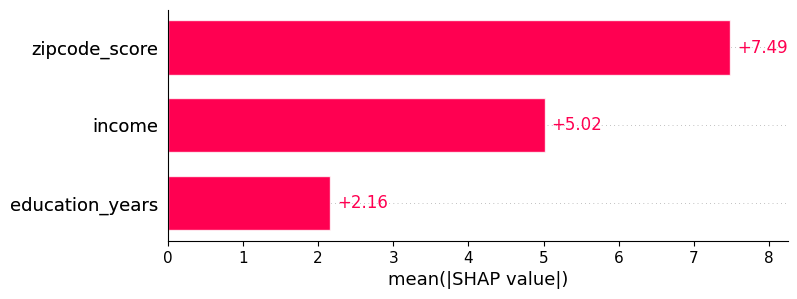

In [9]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [10]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [11]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.086254,-0.170779,5.866534
1,1.020094,-0.192841,-6.859435


### Let's put `group` and `zipcode_score` in the same plot

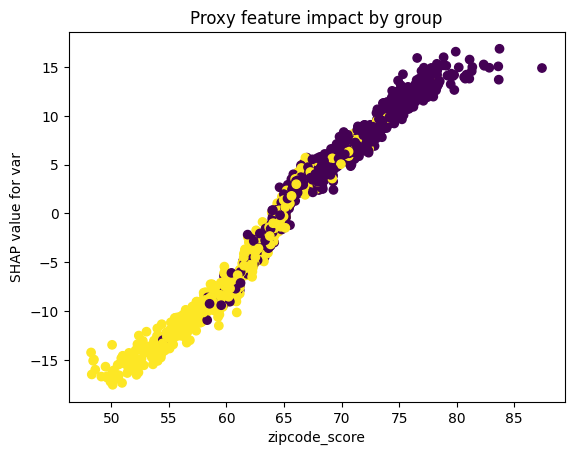

In [12]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("zipcode_score")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value?

SHAP values explain how much each feature contributed to a model's prediction for a specific data point. Positive value means feature pushed prediction higher. Negative value means feature pushed prediction lower.

### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

The variable group was explicitly excluded from the model. The model was trained only on features income, education years, and zipcode score. The group variable was held out specifically to test for potential bias after model development

### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

Yes, the model's prediction appear to be correlated with the group variable, even though it wasn't used in training.

### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

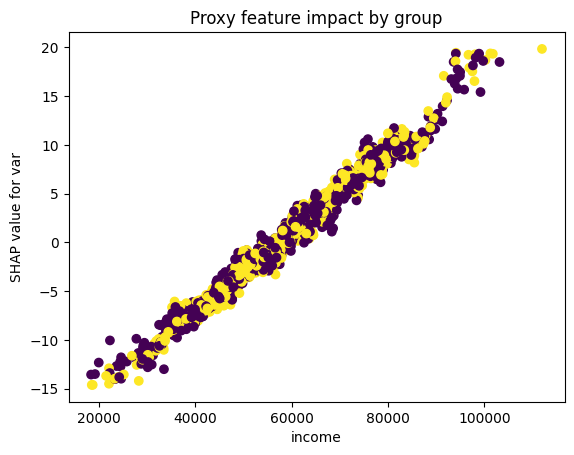

In [13]:
plot_shap("income")

Income plot: Groups are mixed together with similar pattern ---> fair feature
Zipcode_score plot: Groups are clearly seperated with different patterns --> biased feautre (acts as proxy for group)

### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.

What is the correlation between zipcode_score and group in your dataset?
Have you considered removing zipcode_score from the model to reduce disparate impact?